In [30]:
import numpy as np
import gpytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

print(np.__version__)
print(torch.__version__)
print(gpytorch.__version__)

1.24.3
2.0.0+cu117
1.11


In [31]:
class Sine_Task():
    """
    A sine wave data distribution object with interfaces designed for MAML.
    """
    def __init__(self, amplitude, phase, xmin, xmax):
        self.amplitude = amplitude
        self.phase = phase
        self.xmin = xmin
        self.xmax = xmax

    def true_function(self, x):
        """
        Compute the true function on the given x.
        """
        return self.amplitude * np.sin(self.phase + x)

    def sample_data(self, size=1, noise=0.0, sort=False):
        """
        Sample data from this task.

        returns:
            x: the feature vector of length size
            y: the target vector of length size
        """
        x = np.random.uniform(self.xmin, self.xmax, size)
        if(sort): x = np.sort(x)
        y = self.true_function(x)
        if(noise>0): y += np.random.normal(loc=0.0, scale=noise, size=y.shape)
        x = torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y = torch.tensor(y, dtype=torch.float)
        return x, y

In [32]:
class Task_Distribution():
    """
    The task distribution for sine regression tasks for MAML
    """

    def __init__(self, amplitude_min, amplitude_max, phase_min, phase_max, x_min, x_max, family="sine"):
        self.amplitude_min = amplitude_min
        self.amplitude_max = amplitude_max
        self.phase_min = phase_min
        self.phase_max = phase_max
        self.x_min = x_min
        self.x_max = x_max
        self.family = family

    def sample_task(self):
        """
        Sample from the task distribution.

        returns:
            Sine_Task object
        """
        amplitude = np.random.uniform(self.amplitude_min, self.amplitude_max)
        phase = np.random.uniform(self.phase_min, self.phase_max)
        if(self.family=="sine"):
            return Sine_Task(amplitude, phase, self.x_min, self.x_max)
        else:
            return None

## Defining model

In [33]:
class Feature(nn.Module):
    def __init__(self):
        super(Feature, self).__init__()
        self.layer1 = nn.Linear(1, 40)
        self.layer2 = nn.Linear(40,40)
        #self.layer3 = nn.Linear(40,1)
        
    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        #out = self.layer3(out)
        return out

In [34]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=40)
        self.covar_module.initialize_from_data(train_x, train_y)
        #self.feature_extractor = feature_extractor
        
    def forward(self, x):
        #z = self.feature_extractor(x)
        #z_normalized = z - z.min(0)[0]
        #z_normalized = 2 * (z_normalized / z_normalized.max(0)[0]) - 1
        #x_normalized = x - x.min(0)[0]
        #x_normalized = 2 * (x_normalized / x_normalized.max(0)[0]) - 1
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [35]:
n_shot_train = 10
n_shot_test = 10
train_range=(-5.0, 5.0)
test_range=(-5.0, 5.0) # This must be (-5, +10) for the out-of-range condition
criterion = nn.MSELoss()
tasks     = Task_Distribution(amplitude_min=0.1, amplitude_max=5.0, 
                                  phase_min=0.0, phase_max=np.pi, 
                                  x_min=train_range[0], x_max=train_range[1], 
                                  family="sine")
net       = Feature()
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.GreaterThan(1e-4))
# likelihood.noise = 1e-4
dummy_inputs = torch.zeros([n_shot_train,40])
dummy_labels = torch.zeros([n_shot_train])
gp = ExactGPModel(dummy_inputs, dummy_labels, likelihood)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)
optimizer = torch.optim.Adam([{'params': gp.parameters(), 'lr': 1e-3},
                              {'params': net.parameters(), 'lr': 1e-3}])

## Training

In [36]:
import time

likelihood.train()
gp.train()
net.train()

tot_iterations=10000 #50000

t = time.time_ns()

for epoch in range(tot_iterations):
    # gp.likelihood.noise = 1e-2
    optimizer.zero_grad()
    inputs, labels = tasks.sample_task().sample_data(n_shot_train, noise=0.1)
    z = net(inputs)
    with gpytorch.settings.cholesky_jitter(float_value=1e-3, double_value=1e-4, half_value=None):
        gp.set_train_data(inputs=z, targets=labels)  
        predictions = gp(z)
        loss = -mll(predictions, gp.train_targets)
        loss.backward()
        optimizer.step()
        mse = criterion(predictions.mean, labels)
    #---- print some stuff ----
    print(epoch)
    if(epoch%1000==0):
        print(predictions.mean)
        print('[%d] - Loss: %.3f  MSE: %.3f  lengthscale: %.3f   noise: %.3f' % (
            epoch, loss.item(), mse.item(),
            0.0, #gp.covar_module.base_kernel.lengthscale.item(),
            gp.likelihood.noise.item()
        ))
print(f"Total time : {(time.time_ns()-t)/1e9} s")

NanError: cholesky_cpu: 100 of 100 elements of the torch.Size([10, 10]) tensor are NaN.

## Test phase on a new sine

In [10]:
tasks_test = Task_Distribution(amplitude_min=0.1, amplitude_max=5.0, 
                                phase_min=0.0, phase_max=np.pi, 
                                x_min=test_range[0], x_max=test_range[1], 
                                family="sine")

In [11]:
print("Test, please wait...")

likelihood.eval()    
net.eval()
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Trainable parameters : {trainable_params}")
not_trainable_params = sum(p.numel() for p in net.parameters() if not p.requires_grad)
print(f"Non Trainable parameters : {not_trainable_params}")

tot_iterations=500
mse_list = list()
for epoch in range(tot_iterations):
    sample_task = tasks_test.sample_task()
    sample_size = 200
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    indices = np.arange(sample_size)
    np.random.shuffle(indices)
    support_indices = np.sort(indices[0:n_shot_test])

    query_indices = np.sort(indices[n_shot_test:])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]

    #Feed the support set
    z_support = net(x_support).detach()
    gp.train()
    gp.set_train_data(inputs=z_support, targets=y_support, strict=False)  
    gp.eval()

    #Evaluation on query set
    z_query = net(x_query).detach()
    mean = likelihood(gp(z_query)).mean

    mse = criterion(mean, y_query)
    mse_list.append(mse.item())

print("-------------------")
print("Average MSE: " + str(np.mean(mse_list)) + " +- " + str(np.std(mse_list)))
print("-------------------")

Test, please wait...
Trainable parameters : 1720
Non Trainable parameters : 0
-------------------
Average MSE: 0.410981863329187 +- 0.7322850443089481
-------------------


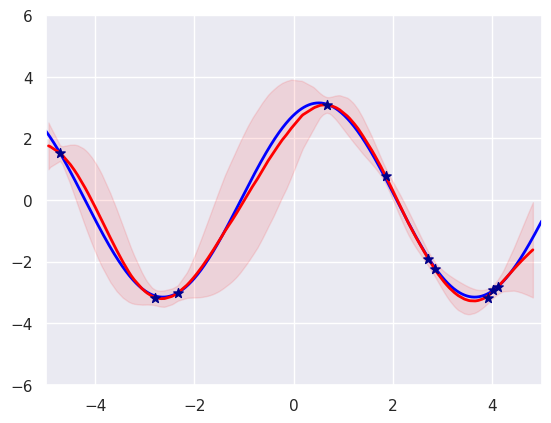

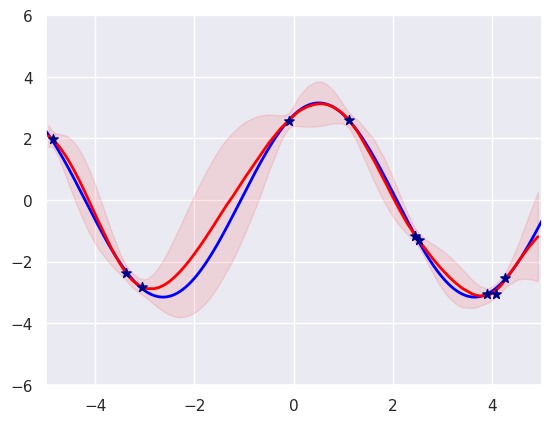

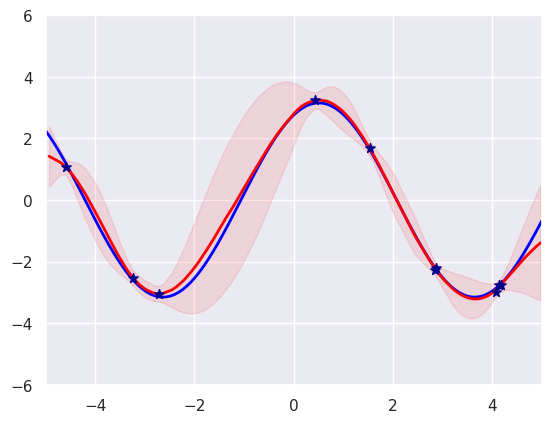

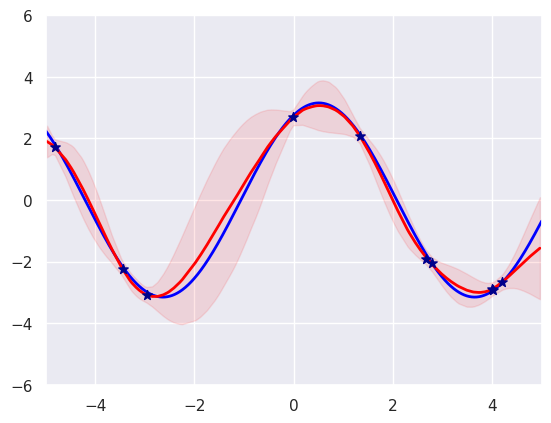

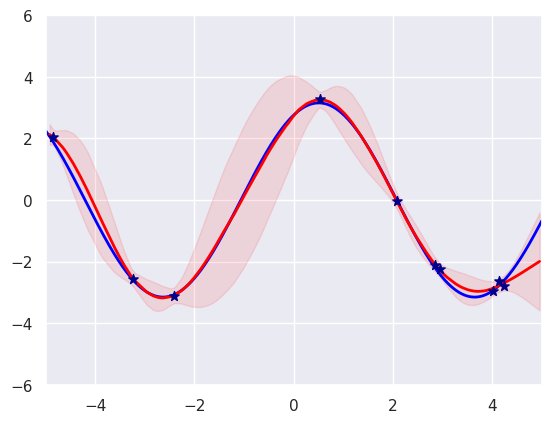

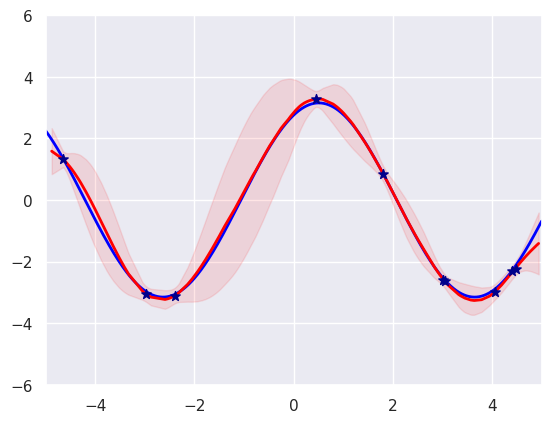

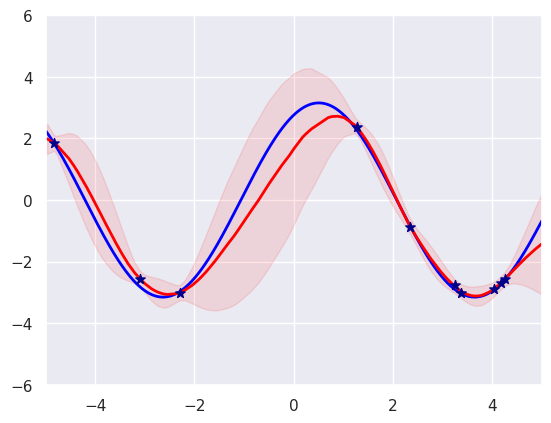

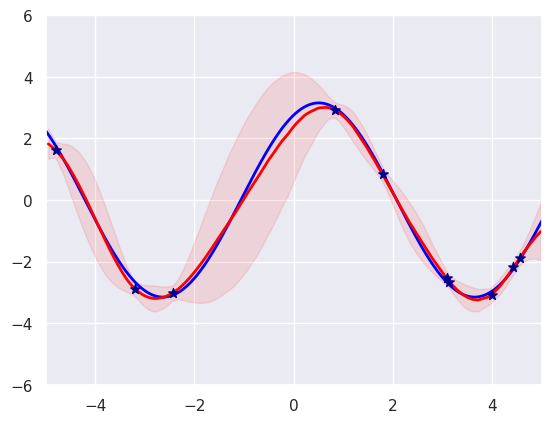

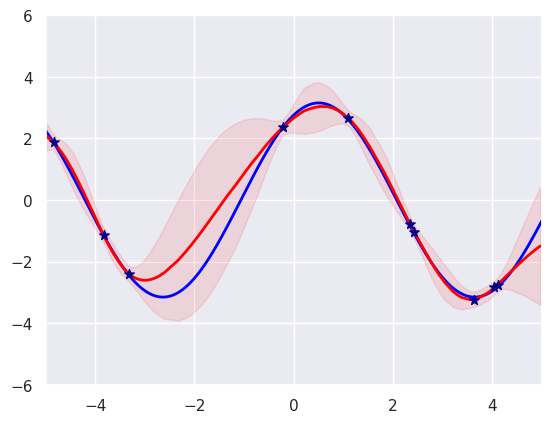

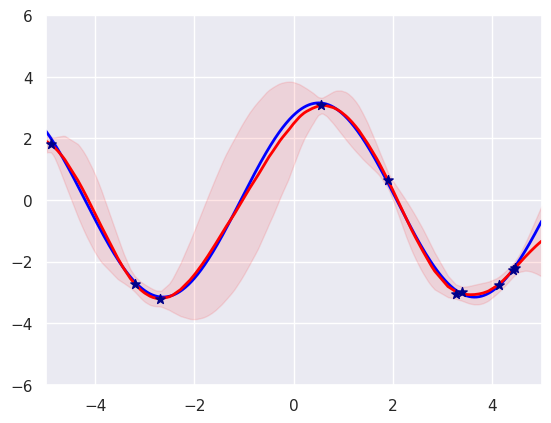

In [12]:
for i in range(10):
    x_all, y_all = sample_task.sample_data(sample_size, noise=0.1, sort=True)
    query_indices = np.sort(indices[n_shot_test:])
    x_support = x_all[support_indices]
    y_support = y_all[support_indices]
    x_query = x_all[query_indices]
    y_query = y_all[query_indices]
    
    z_support = net(x_support).detach()
    gp.train()
    gp.set_train_data(inputs=z_support, targets=y_support, strict=False)  
    gp.eval()
            
    #Evaluation on all data
    z_all = net(x_all).detach()
    mean = likelihood(gp(z_all)).mean
    lower, upper = likelihood(gp(z_all)).confidence_region() #2 standard deviations above and below the mean

    #Plot
    fig, ax = plt.subplots()
    #true-curve
    true_curve = np.linspace(train_range[0], train_range[1], 1000)
    true_curve = [sample_task.true_function(x) for x in true_curve]
    ax.plot(np.linspace(train_range[0], train_range[1], 1000), true_curve, color='blue', linewidth=2.0)
    if(train_range[1]<test_range[1]):
        dotted_curve = np.linspace(train_range[1], test_range[1], 1000)
        dotted_curve = [sample_task.true_function(x) for x in dotted_curve]
        ax.plot(np.linspace(train_range[1], test_range[1], 1000), dotted_curve, color='blue', linestyle="--", linewidth=2.0)
    #query points (ground-truth)
    #ax.scatter(x_query, y_query, color='blue')
    #query points (predicted)

    ax.plot(np.squeeze(x_all), mean.detach().numpy(), color='red', linewidth=2.0)
    ax.fill_between(np.squeeze(x_all),
                    lower.detach().numpy(), upper.detach().numpy(),
                    alpha=.1, color='red')
    #support points
    ax.scatter(x_support, y_support, color='darkblue', marker='*', s=50, zorder=10)
                    
    #all points
    #ax.scatter(x_all.numpy(), y_all.numpy())
    #plt.show()
    plt.ylim(-6.0, 6.0)
    plt.xlim(test_range[0], test_range[1])
    plt.savefig('plot_DKT_' + str(i) + '.png', dpi=300)